# Collaborative Filtering #

Collaborative filtering is a popular approach to creating recommender systems. Suppose we have the following problem:

User A gave five stars to _Titanic_ and _The Notebook_, and one star to _Captain America_ and _Dark Knight Rises_. Should we recommend to User A a film like _Love Actually_? What about _Batman vs Superman_?

In this case it's easy to tell what User A prefers since we have prior knowledge about the films. But how can we develop recommendations without this knowledge? 

It turns out that if we have rating data from many users it's possible to learn the underlying features that define a movie (genre, certain actors/directors, etc.) as well as the preferences of each user for each feature. Then, by identifying the features for a particular movie, and the preferences of a particular user, we can decide whether that movie would be a good recommendation. 

# Low Rank Matrix Factorization #

One method of implementing collaborative filtering is low rank matrix factorization. Suppose we have a matrix of ratings, with one column for each user and one row for each item. Call this matrix $Y$. A small number of the elements in the matrix will have values (the rating user A gives to item B, if it exists), but the vast majority of elements will be unknown. We also have a matrix $R$ which contains 1 in locations where a rating exists and 0 where a rating has not been given. Both $R$ and $Y$ have dimension $n_{items}$ by $n_{users}$. 

The process described above of learning underlying features and preferences is described mathematically by:

$ Y = X \theta^{T} $

$X$ is a matrix with dimension $n_{items}$ by $n_{features}$ and $\theta$ is a matrix with dimension $n_{users}$ by $n_{features}$. Each row in $X$ is the representation of a particular item as a linear combination of features, and each row in $\theta$ represents the preferences of a particular user for each feature. Note that a feature might be some characteristic such as genre or author - but it may also be very difficult to interpret. The beauty of the algorithm is that it will automatically choose the most meaningful features.

# Training and Implementation #

The goal of our algorithm is to find appropriate matrices $X$ and $\theta$ such that $X \theta^{T}$ approximates $Y$. However, it only needs to approximate $Y$'s values where a rating has actually been given - for some user A who has not rated item B, the value given by $X \theta^{T}$ at column A and row B is the _predicted_ rating that user A will give to item B. 

We can find $X$ and $\theta$ using gradient descent. The loss function will be the sum-of-squares loss between $X \theta^{T}$ and $Y$, _but only evaluated on locations where a rating has been given_, i.e. where $R_{i,j}=1$. Similarly, the gradient is only computed at these locations as well. 

For this particular analysis, the goal is to recommend programming languages for you to learn, given some languages you already like. We will approximate the preferences of users with the languages used in GitHub repositories. The items we rate will be languages. Once we compute $X$ and $\theta$, the recommended languages will be those with the highest predicted ratings. 

# Acquiring Data From BigQuery #

We will import a relatively small number of repositories (for speed) and their language details. 

In [48]:
import os
import pandas
import numpy as np

from google.cloud import bigquery
client = bigquery.Client()

QUERY = """
        SELECT repo_name, language
        FROM `bigquery-public-data.github_repos.languages`
        ORDER BY rand()
        LIMIT 200
        """

query_job = client.query(QUERY)

iterator = query_job.result(timeout=30)
rows = list(iterator)

for i in range(10):
    print 'Repository '+str(i+1)
    for j in rows[i].language:
        print j[u'name']+': '+str(j[u'bytes'])+' bytes'
    print 
print '...'

Repository 1
C#: 91187 bytes

Repository 2
Vim script: 8707 bytes

Repository 3
CSS: 866 bytes
JavaScript: 12569 bytes

Repository 4
Ruby: 3005 bytes

Repository 5
CSS: 664 bytes
Ruby: 1497 bytes

Repository 6
Ragel in Ruby Host: 4794 bytes
Ruby: 61628 bytes

Repository 7
Batchfile: 1653 bytes
CSS: 4059 bytes
HTML: 20663 bytes
JavaScript: 51872 bytes
Ruby: 1509 bytes
Shell: 3123 bytes

Repository 8

Repository 9
Ruby: 1926 bytes

Repository 10
Ruby: 101097 bytes

...


# List of Languages #

Create a list of all languages in the given sample.

In [49]:
names = {}
for i in range(len(rows)):
    for j in rows[i].language:
        if j[u'name'] in names:
            names[j[u'name']]+=1
        else:
            names[j[u'name']]=1

names = [n for n in names if names[n]>1]
for i in range(10):
    print names[i]
print '...'

name_to_index = {}
for j,i in enumerate(names):
    name_to_index[i] = j
print str(len(names))+" languages"

GLSL
TypeScript
Java
Scala
ApacheConf
JavaScript
Makefile
Perl
Lua
Erlang
...
33 languages


# Repository-Language Matrix #

Create a matrix where each row represents a repository and each column represents a language. This matrix is our Y (i.e. what we are trying to predict). Here, if a language A is used in repository B, this is considered as repository B giving A a rating. If A is not used in B, then there is no rating (rather than a rating of 0). 

The value in the matrix is 0 if the language is not present in the repository; otherwise, it is the logarithm of the number of bytes in the repository in that particular language, divided by the sum of the logarithms of the number of bytes of each language in the repository. The logarithm was chosen so the number-of-bytes information could be used, but languages with fewer bytes would not be underrepresented.

In [50]:
from math import log

global mat
mat = np.zeros((len(rows),len(names)))
for i,row in enumerate(rows):
    total = sum([log(lang[u'bytes']) if lang[u'bytes']!=0 else 0 for lang in row[1]])
    for lang in rows[i].language:
        if lang[u'name'] in name_to_index:
            mat[i][name_to_index[lang[u'name']]] = (log(lang[u'bytes']) if lang[u'bytes']!=0 else 0)/total if total!=0 else 0
mat = mat[~np.all(mat==0,axis=1)]

# PCA #

Using PCA we can define roughly the number of features we want to identify the low rank matrix factorization. The graph below shows the amount of unexplained variance plotted against the number of components used. The "elbow" of the graph (at around n=15) is typically used.

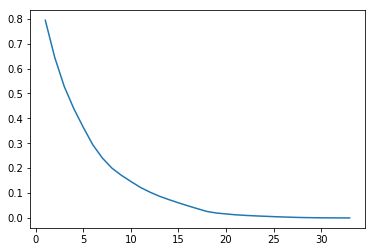

In [51]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

%matplotlib inline

n_components = min(50,len(names))
pca = PCA(n_components=n_components)
transformed = pca.fit_transform(mat) 

evr = [1-sum(pca.explained_variance_ratio_[:i+1]) for i in range(len(pca.explained_variance_ratio_))]
plt.plot(range(1,n_components+1),evr)

# Loss Function and Gradient #

We define some useful functions. 

init_mask: Create a mask matrix that indicates where Y has meaningful values. 

loss: Sum-of-squares loss, with a regularization term to prevent overfitting. The matrices theta and X are multiplied to give a "best guess", which is then compared with the target matrix Y, but only in locations where a rating has been given.

gradient: Derivative of loss with respect to theta and X, with a regularization term. 

These functions will be useful in performing gradient descent.

In [52]:
n_features = 15
filter_size = min(100,len(mat[0]))
mat = mat[:,range(filter_size)] if len(mat[0])>filter_size else mat #for speed
global mask,n_repos,n_langs,reg_param
reg_param = 0.00001

#mask
def init_mask(Y=mat):
    f = np.vectorize(lambda x: 1 if x>0 else 0)
    return f(Y),len(Y),len(Y[0])

#loss
def loss(args, Y=mat):
    theta = np.reshape(args[:n_repos*n_features],(n_repos,n_features))
    X = np.reshape(args[n_repos*n_features:],(n_langs,n_features))
    g = np.vectorize(lambda x: x*x)
    return 0.5*np.sum(np.multiply(g(np.subtract(np.matmul(theta,np.transpose(X)),Y)),mask))+reg_param/2*np.sum(g(args))

#gradient
def gradient(args, Y=mat):
    theta = np.reshape(args[:n_repos*n_features],(n_repos,n_features))
    X = np.reshape(args[n_repos*n_features:],(n_langs,n_features))
    X_grad = np.matmul(np.transpose(np.multiply(np.subtract(np.matmul(theta,np.transpose(X)),Y),mask)),theta)+reg_param*X
    theta_grad = np.matmul(np.multiply(np.subtract(np.matmul(theta,np.transpose(X)),Y),mask),X)+reg_param*theta
    return np.concatenate((np.reshape(theta_grad,-1),np.reshape(X_grad,-1)))

# Training #

Gradient descent is performed using loss and gradient as defined above. This will iteratively improve matrices theta and X, so that their product more closely matches the target matrix Y. 

In [53]:
import scipy.optimize as op

def train(Y=mat):
    theta = np.random.rand(n_repos,n_features)
    X = np.random.rand(n_langs,n_features)
    args = np.concatenate((np.reshape(theta,-1),np.reshape(X,-1)))

    args = op.fmin_cg(loss,args,gradient,maxiter=10000)

    theta = np.reshape(args[:n_repos*n_features],(n_repos,n_features))
    X = np.reshape(args[n_repos*n_features:],(n_langs,n_features))
    
    return theta,X

# Recommendations #

Now, you can test the recommender system. Type in your favorite language (or a space-separated list of your favourite languages), and 5 new languages will be recommended for you to learn. The training process may take some time.

In [58]:
string = raw_input("Enter some languages: ")
print
langs = string.split(' ')
lc_names = {str(name).lower(): name_to_index[name] for name in name_to_index}

test = np.zeros((1,len(names)))
known = set()
for lang in langs:
    if lang.lower() in lc_names:
        test[0][lc_names[lang.lower()]] = 1
        known.add(lc_names[lang.lower()])
                       
mat = np.concatenate((mat,test[:,range(filter_size)]),0)
mask,n_repos,n_langs = init_mask()
theta,X = train(mat)
mat = mat[:-1]
    
predictions = np.matmul(theta,np.transpose(X))[-1].tolist()
predictions = sorted([(abs(j),i) for i,j in enumerate(predictions)],reverse=True)
    
print
i = 0
for val,name in predictions:
    if name not in known:
        print str(i+1)+': '+names[name]+' - '+str(val)
        i+=1
    if i>=5:
        break

Enter some languages: html css

         Current function value: 0.001695
         Iterations: 10000
         Function evaluations: 15290
         Gradient evaluations: 15290

1: Haskell - 1.29583885423
2: Clojure - 1.20321059029
3: Scala - 1.13094744043
4: Perl - 1.03885669958
5: Erlang - 1.01627024842


When you type in the list of languages, the recommender system adds that extra row to target matrix Y. Then, training is performed on your language preferences simultaneously as those of all the repositories in the sample. Finally, the trained matrices theta and X are multiplied, and the last row corresponds to the predicted ratings based on your preferences. The highest values are the languages recommended to you. 